2024-07-31 17:28:38.047867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:28:38.048019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:28:38.211658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


                                         id label
0  f38a6374c348f90b587e046aac6079959adf3835     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1
2  755db6279dae599ebb4d39a9123cce439965282d     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0
4  068aba587a4950175d04c680d38943fd488d6a9d     0


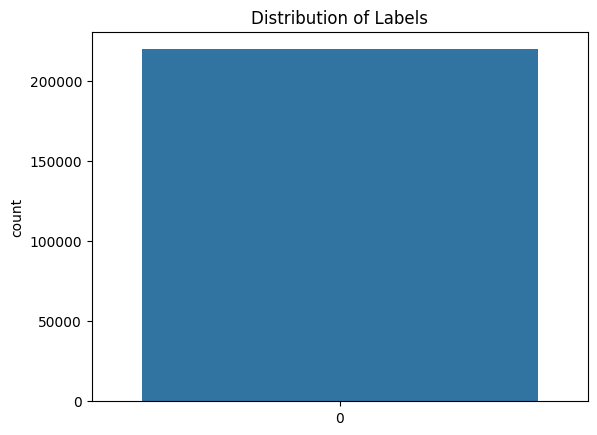

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Load the training labels
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Ensure labels are strings for compatibility with flow_from_dataframe
train_labels['label'] = train_labels['label'].astype(str)

# Display the first few rows of the dataframe
print(train_labels.head())

# Visualize the distribution of labels
sns.countplot(train_labels['label'])
plt.title('Distribution of Labels')
plt.show()

In [2]:
# Add the '.tif' extension to the IDs in the dataframe
train_labels['id'] = train_labels['id'].apply(lambda x: f"{x}.tif")

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)

# Flow from dataframe for training set
train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='id',
    y_col='label',
    subset='training',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)

# Flow from dataframe for validation set
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='id',
    y_col='label',
    subset='validation',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)

# Print number of samples in the generators
print(f"Found {train_generator.samples} training images.")
print(f"Found {validation_generator.samples} validation images.")

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 176020 training images.
Found 44005 validation images.


In [3]:
from tensorflow.keras.layers import Input

# Building a simple CNN model
model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=5
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 2704s 491ms/step - accuracy: 0.7652 - loss: 0.5028 - val_accuracy: 0.7917 - val_loss: 0.4726
Epoch 2/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.8438 - loss: 0.4059 - val_accuracy: 0.6000 - val_loss: 0.6667
Epoch 3/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 2238s 407ms/step - accuracy: 0.8247 - loss: 0.4091 - val_accuracy: 0.8241 - val_loss: 0.4004
Epoch 4/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.7812 - loss: 0.3752 - val_accuracy: 0.6000 - val_loss: 0.6273
Epoch 5/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 2202s 400ms/step - accuracy: 0.8366 - loss: 0.3825 - val_accuracy: 0.8394 - val_loss: 0.3872


In [5]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 258s 187ms/step - accuracy: 0.8384 - loss: 0.3889
Validation Loss: 0.386367529630661, Validation Accuracy: 0.8410862684249878


In [6]:
# Path to test images
test_data_path = '/kaggle/input/histopathologic-cancer-detection/test/'

# Prepare test generator
test_filenames = os.listdir(test_data_path)
test_df = pd.DataFrame({
    'id': [filename.split('.')[0] for filename in test_filenames],
    'filename': [filename for filename in test_filenames]
})
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df,
    directory=test_data_path,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(96, 96),
    batch_size=32,
    shuffle=False
)

# Predict on test data
predictions = model.predict(test_gen)
# Assuming the model outputs probabilities, convert them to binary labels
test_df['label'] = (predictions > 0.5).astype(int)

# Save the predictions
test_df[['id', 'label']].to_csv('submission.csv', index=False)

Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 337s 187ms/step
